# 1. Basic examples

## Prepare LN data

In order to run the simulation you need to provide LN snapshots as well as information about merchants nodes. In this notebooks you can try our LN traffic simulator on a small sample data. **If you want to use the full data set related to our work then please follow the instructions in the [documentation](https://lnsimulator.readthedocs.io/en/latest/getting_started.html#data).**

### LN snapshots

The network structure is fed to `lnsimulator` in the form of LN snapshots. Raw JSON files as well as preprocessed payment channel data can be used as input.

#### Load data from JSON file

In [4]:
import sys
sys.path.append('../')
from lnsimulator.ln_utils import preprocess_json_file

In [5]:
data_dir = "/Users/puri/DataScience@SMU/04.DS7330 File Org. and DB Management/TermProjectfiles/LNTrafficSimulator/sample_data"
directed_edges = preprocess_json_file("%s/sample.json" % data_dir)


i.) Load data
/Users/puri/DataScience@SMU/04.DS7330 File Org. and DB Management/TermProjectfiles/LNTrafficSimulator/sample_data/sample.json 2844 22460
All edges: 22460
All edges without loops: 22460
2844 22460
Remove records with missing node policy
node1_pub       0.000000
node2_pub       0.000000
last_update     0.000000
capacity        0.000000
channel_id      0.000000
node1_policy    0.000312
node2_policy    0.000134
snapshot_id     0.000000
dtype: float64
10

ii.) Transform undirected graph into directed graph


100%|██████████| 22450/22450 [00:07<00:00, 3057.52it/s]



iii.) Fill missing policy values with most frequent values
missing values for columns:
snapshot_id            0
src                    0
trg                    0
last_update            0
channel_id             0
capacity               0
disabled               0
fee_base_msat          0
fee_rate_milli_msat    0
min_htlc               0
dtype: int64


### Merchants

We provided the list of LN merchants that we used in our experiments. This merchant information was collected in early 2019.

In [6]:
import pandas as pd
node_meta = pd.read_csv("%s/1ml_meta_data.csv" % data_dir)
providers = list(node_meta["pub_key"])

## Configuration

First we give you the list of main parameters.

| Parameter | Description |
|     :---      |   :---   |
| `amount` |  value of each simulated transaction in satoshis  |
| `count`  | number of random transactions to sample  |
| `epsilon` |  ratio of merchants among transactions endpoints  |
| `drop_disabled` | drop temporarily disabled channels |
| `drop_low_cap` | drop channels with capacity less than `amount` |
| `with_depletion` | the available channel capacity is maintained for both endpoints |

You can initialize the traffic simulator by providing the network structure, merchants information and the former parameters.

In [7]:
import lnsimulator.simulator.transaction_simulator as ts

amount = 60000
count = 7000
epsilon = 0.8
drop_disabled = True
drop_low_cap = True
with_depletion = True

simulator = ts.TransactionSimulator(directed_edges, providers, amount, count, drop_disabled=drop_disabled, drop_low_cap=drop_low_cap, epsilon=epsilon, with_depletion=with_depletion)

## Estimating daily income and traffic

### i.) Transactions

The simulator samples a set of random transactions (during the initialization) that will be used for the estimation of daily node traffic and routing income. You can access the sampled transactions in the form of a `pandas.DataFrame`.

In [8]:
transactions = simulator.transactions
print(transactions.head())
print(transactions.shape)

   transaction_id                                             source  \
0               0  03e0a26dca5f4d4dea43ba104d41e4f54b6b66c5b25598...   
1               1  02626318f968469fb1dcd0453536bbabaab8861be75d8c...   
2               2  02450500fa04c03e76ce1f01d5338006111bf5347fabfc...   
3               3  02c8d0eef6feed8479662070608b76f5bb3527a891e9f0...   
4               4  02098684c9d7a9ec27071faf09f1442c228a8778c01903...   

                                              target  amount_SAT  
0  031f8400b123834edd5736de9aac14ec0d77c11bff27f5...       60000  
1  02868e12f320073cad0c2959c42559fbcfd1aa326fcb94...       60000  
2  03b6cad4d044d42e9d9537650dd4a84806733dd00013f8...       60000  
3  021607cfce19a4c5e7e6e738663dfafbbbac262e4ff76c...       60000  
4  021d9deaf090a021c6e464e3becc5296161e8aaf5de3c7...       60000  
(6998, 4)


### ii.) Run simulation

In this step the simulator searches for cheapest payment paths from transaction senders to its receivers. Channel capacity changes are well maintained during the simulation. 

In [9]:
cheapest_paths, _, all_router_fees, _ = simulator.simulate(weight="total_fee", with_node_removals=False)

Graph and capacities were INITIALIZED
Transactions simulated on original graph STARTED..
Transactions simulated on original graph DONE
Transaction succes rate:
True     0.591883
False    0.408117
Name: success, dtype: float64


### iii.) Results

After payment simulation you can export the results as well as calculate traffic and income statistics for LN nodes.

In [10]:
output_dir = "test"
total_income, total_fee = simulator.export(output_dir)

Export DONE


In order to get stable daily LN node statistics, we recommend to run the simulator for multiple times over several consecutive snapshots. **Node statistics in each output file below are restricted to a single traffic simulator experiment!** You can find these file in the `output_dir` folder.

#### a.) lengths_distrib.csv

Distribution of payment path length for the sampled transactions. Due to the source routing nature of LN, we assumed that transactions are executed on the cheapest path between the sender and the recipient.

| Column | Description |
|     :---      |   :---   |
| First | Payment path length |
| Second | Number of sampled transactions with given length |

**Note:** the length is marked -1 if the payment failed (there was no available path for routing)

**Note:** the sum of transactions in the second column could be less then the predefined number of payments to simulate. The difference is the number of randomly sampled loop transactions with identical sender and recipient node.

#### b.) router_incomes.csv

Contains statistics on nodes that forwarded payments in the simulation. We refer to these nodes as **routers**.

| Column | Description |
|     :---      |   :---   |
| node | LN node public key |
| fee | routing income |
| num_trans | number of routed transactions |

#### c.) source_fees.csv

Contains statistics on payment initiator nodes (senders).

| Column | Description |
|     :---      |   :---   |
| source | LN node that initiated the payment (sender node) |
| num_trans | the number of transactions initiated by this node in the simulation |
| mean_fee | the mean transaction cost per payment |

## Useful function calls

There are alternative ways to interact with the simulator object beside exporting the results (with the `simulator.export(output_dir)` function). Please follow the examples below.

#### Top nodes with highest daily income

You can search for the identity of these nodes on [1ml.com](https://1ml.com).

In [11]:
total_income.sort_values("fee", ascending=False).set_index("node").head(5)

,fee,num_trans
node,,
03e50492eab4107a773141bb419e107bda3de3d55652e6e1a41225f06a0bbf2d56,4681.0,31
0232e20e7b68b9b673fb25f48322b151a93186bffe4550045040673797ceca43cf,2404.0,4
0279c22ed7a068d10dc1a38ae66d2d6461e269226c60258c021b1ddcdfe4b00bc4,1980.0,33
032679fec1213e5b0a23e066c019d7b991b95c6e4d28806b9ebd1362f9e32775cf,1586.0,52
03fb822818be083e0a954db85257a2911a3d55458b8c1ea4124b157e865a836d12,823.5,27


#### Top nodes with highest daily traffic

In [12]:
total_income.sort_values("num_trans", ascending=False).set_index("node").head(5)

,fee,num_trans
node,,
02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f0c544b34c1c6f3b9a02b,71.4605,1190
03bb88ccc444534da7b5b64b4f7b15e1eccb18e102db0e400d4b9cfe93763aa26d,79.2800,813
03ee180e8ee07f1f9c9987d98b5d5decf6bad7d058bdd8be3ad97c8e0dd2cdc7ba,27.2600,446
0331f80652fb840239df8dc99205792bba2e559a05469915804c08420230e23c7c,349.8000,330
03a76b80027d7c067e0da77da95880faaf89e9bf87b73a7d57bd4a3f2a124b764f,14.5200,242


#### Payment path length distribution

**Note:** the length is marked -1 if the payment failed (there was no available path for routing)

In [13]:
cheapest_paths["length"].value_counts()

-1     2695
 3     1636
 2     1341
 4      785
 5      261
 1      215
 6       85
 7       28
 8        4
 10       1
 9        1
Name: length, dtype: int64

#### Payment succes ratio

In [14]:
(cheapest_paths["length"] > -1).value_counts() / len(cheapest_paths)

True     0.617839
False    0.382161
Name: length, dtype: float64

#### Payment cost statistics

In [15]:
cheapest_paths["original_cost"].describe()

count    4357.000000
mean        5.720739
std        24.856801
min         0.000000
25%         0.220000
50%         1.120000
75%         2.120000
max       661.060000
Name: original_cost, dtype: float64

#### Most frequent payment receivers

In [16]:
simulator.transactions["target"].value_counts().head(5)

02cdf83ef8e45908b1092125d25c68dcec7751ca8d39f557775cd842e5bc127469    416
0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266    298
021607cfce19a4c5e7e6e738663dfafbbbac262e4ff76c2c9b30dbeefc35c00643    289
0232e20e7b68b9b673fb25f48322b151a93186bffe4550045040673797ceca43cf    235
038ddc73e450a4bfb52992b35be8b0f52e1a1b4726ff319249a3314a508b616cde    228
Name: target, dtype: int64

#### Number of unique payment senders and receivers

In [17]:
simulator.transactions["source"].nunique(), simulator.transactions["target"].nunique()

(2463, 1172)

# 2. Advanced examples

## Parameters explained

Here is the list of main parameters. **By the word "transaction" we refer to LN payments.**

| Parameter | Description | Default value |
|     :---      |   :---   | :---
| `amount` |  value of each simulated transaction in satoshis  | **Must be set** |
| `count`  | number of random transactions to sample  | **Must be set** |
| `epsilon` |  ratio of merchants among transactions endpoints  | 0.8 |
| `drop_disabled` | drop temporarily disabled channels | True |
| `drop_low_cap` | drop channels with capacity less than `amount` | True |
| `with_depletion` | the available channel capacity is maintained for both endpoints | True |

The following examples will help you to understand the effect of each parameter. As `amount` and `count` are very straightforward parameters we will start with how to set merchant ratio for payment receivers.

### Merchant ratio for payment receivers

The number of unique receivers is the highest when **receivers sampled uniformly at random** (`epsilon=0.0`) while you have the chance to send payments **only to merchants** (`epsilon=1.0`). In most of our experiments we sample merchant receivers with high probability (`epsilon=0.8`) but we also select random receivers as well with small probability.

In [18]:
only_merchant_receivers = ts.TransactionSimulator(directed_edges, providers, amount, count, epsilon=1.0)
many_merchant_receivers = ts.TransactionSimulator(directed_edges, providers, amount, count, epsilon=0.8)
uniform_receivers = ts.TransactionSimulator(directed_edges, providers, amount, count, epsilon=0.0)
print(only_merchant_receivers.transactions["target"].nunique())
print(many_merchant_receivers.transactions["target"].nunique())
print(uniform_receivers.transactions["target"].nunique())

124
1183
2461


### Control channel exclusion with `drop_disabled` and `drop_low_cap`

Channels can be temporarily disabled for a given snapshot while active for others. If you want to **enable disabled channels** in your experiments then use `drop_disabled=False`. But 

In [19]:
default_sim = ts.TransactionSimulator(directed_edges, providers, amount, count, drop_disabled=True, drop_low_cap=True)
with_disabled_sim = ts.TransactionSimulator(directed_edges, providers, amount, count, drop_disabled=False, drop_low_cap=True)
print(default_sim.edges.shape)
print(with_disabled_sim.edges.shape)

(31539, 4)
(38044, 4)


A payment can only be forwarded on a given channel if the channel capacity is at least the value of the payment (`drop_low_cap=True`). But in the simulation you have the possibility to disabled this condition (`drop_low_cap=False`).

In [20]:
with_lowcap_sim = ts.TransactionSimulator(directed_edges, providers, amount, count, drop_disabled=False, drop_low_cap=False)
print(with_lowcap_sim.edges.shape)

(41800, 4)


### Updating node balances with payments

Individual balances of LN nodes is a private data but `lnsimulator` can **keep track of capacity imbalances** (`with_depletion=True`) as payments are executed on the fly. After distributing capacities randomly between related channel endpoints (initialization step), our simulator can monitor whether a node has enough outbound capacity on a given channel to forward the upcoming payment with respect to the payment value. This feature has several advantages:

- ability to detect node capacity depletions in case of heavy one-way traffic
- better understanding of payment failures

In case you disable this feature (`with_depletion=False`) payments can pass a channel in a fixed direction infinitely many times as long as the payment value is at most the channel capacity.

In the next example we observe the payment failure ratio with respect to the `with_depletio` parameter.

In [21]:
sim_with_dep = ts.TransactionSimulator(directed_edges, providers, amount, count, with_depletion=True)
_, _, _, _ = sim_with_dep.simulate(weight="total_fee")

Graph and capacities were INITIALIZED
Transactions simulated on original graph STARTED..
Transactions simulated on original graph DONE
Transaction succes rate:
True     0.601915
False    0.398085
Name: success, dtype: float64


In [22]:
sim_wout_dep = ts.TransactionSimulator(directed_edges, providers, amount, count, with_depletion=False)
_, _, _, _ = sim_wout_dep.simulate(weight="total_fee")

Graph and capacities were INITIALIZED
Transactions simulated on original graph STARTED..
Transactions simulated on original graph DONE
Transaction succes rate:
True     0.672717
False    0.327283
Name: success, dtype: float64


Transaction success rates are lower if capacity depletion is enabled (`with_depletion=True`). This indicates that **there are channels with heavy one-way traffic**.

In [23]:
print("Succes rate with depletions:", sim_with_dep.transactions["success"].mean())
print("Succes rate without depletions:", sim_wout_dep.transactions["success"].mean())

Succes rate with depletions: 0.601915380217267
Succes rate without depletions: 0.6727168786622838


## Advanced simulation features

In the past experiment after initializing your simulator the `simulate()` function executed cheapest path routing by default without modifying the available channel data. Now let's see some additional use cases.

In [24]:
sim = ts.TransactionSimulator(directed_edges, providers, amount, count)

### Routing algorithm

For now you can choose between two routing algorithms by setting the `weight` parameter

- **cheapest path** routing (`weight="total_fee"` - DEFAULT SETTING)
- **shortest path** routing (`weight=None`)

In [25]:
shortest_paths, _, _, _ = sim.simulate(weight=None)
cheapest_paths, _, _, _ = sim.simulate(weight="total_fee")

Graph and capacities were INITIALIZED
Transactions simulated on original graph STARTED..
Transactions simulated on original graph DONE
Transaction succes rate:
True     0.601401
False    0.398599
Name: success, dtype: float64
Graph and capacities were INITIALIZED
Transactions simulated on original graph STARTED..
Transactions simulated on original graph DONE
Transaction succes rate:
True     0.5994
False    0.4006
Name: success, dtype: float64


#### Filter out payments that could not be routed (they are denoted with `length==-1`)

Then observe the average path length for the simulated payments

In [26]:
print(shortest_paths[shortest_paths["length"]>0]["length"].mean())
print(cheapest_paths[cheapest_paths["length"]>0]["length"].mean())

2.4200861482656992
3.0


### Node removal

You can observe the effects of node removals as well by providing a list of LN node public keys. In this case every channel adjacent to the given nodes will be removed during payment simulation. 

**In this example we exclude the top 5 nodes with highest routing income**

In [27]:
_, _, all_router_fees, _ = sim.simulate(weight="total_fee")
print("Succes rate BEFORE exclusion:", sim.transactions["success"].mean())

Graph and capacities were INITIALIZED
Transactions simulated on original graph STARTED..
Transactions simulated on original graph DONE
Transaction succes rate:
True     0.600257
False    0.399743
Name: success, dtype: float64
Succes rate BEFORE exclusion: 0.6002572531084751


In [28]:
top_5_stats = all_router_fees.groupby("node")["fee"].sum().sort_values(ascending=False).head(5)
print(top_5_stats)
top_5_nodes = list(top_5_stats.index)

node
0232e20e7b68b9b673fb25f48322b151a93186bffe4550045040673797ceca43cf    10818.0
03e50492eab4107a773141bb419e107bda3de3d55652e6e1a41225f06a0bbf2d56     3624.0
0279c22ed7a068d10dc1a38ae66d2d6461e269226c60258c021b1ddcdfe4b00bc4     3180.0
03d37fca0656558de4fd86bbe490a38d84a46228e7ec1361801f54f9437a18d618     1098.0
032679fec1213e5b0a23e066c019d7b991b95c6e4d28806b9ebd1362f9e32775cf     1067.5
Name: fee, dtype: float64


You can observe how the payment success rate dropped by removing 5 important routers

In [29]:
_, _, _, _ = sim.simulate(weight="total_fee", excluded=top_5_nodes)
print("Succes rate AFTER exclusion:", sim.transactions["success"].mean())

43325 3751
Additional nodes were EXCLUDED!
Graph and capacities were INITIALIZED
Transactions simulated on original graph STARTED..
Transactions simulated on original graph DONE
Transaction succes rate:
True     0.564099
False    0.435901
Name: success, dtype: float64
Succes rate AFTER exclusion: 0.5640988995283693


### Node capacity reduction

You can observe the traffic changes for a node by reducing its capacity to a given fraction of its original value. 

**In this example we reduce capacity to 10% of the top 5 nodes with highest routing income. Then we compare their new income with the original.**

In [30]:
_, _, reduced_fees, _ = sim.simulate(weight="total_fee", cap_change_nodes=top_5_nodes, capacity_fraction=0.1)
print("Succes rate AFTER capacity reduction:", sim.transactions["success"].mean())

Capacity change executed: (['0232e20e7b68b9b673fb25f48322b151a93186bffe4550045040673797ceca43cf', '03e50492eab4107a773141bb419e107bda3de3d55652e6e1a41225f06a0bbf2d56', '0279c22ed7a068d10dc1a38ae66d2d6461e269226c60258c021b1ddcdfe4b00bc4', '03d37fca0656558de4fd86bbe490a38d84a46228e7ec1361801f54f9437a18d618', '032679fec1213e5b0a23e066c019d7b991b95c6e4d28806b9ebd1362f9e32775cf'], 0.1000)
Graph and capacities were INITIALIZED
Transactions simulated on original graph STARTED..
Transactions simulated on original graph DONE
Transaction succes rate:
True     0.591396
False    0.408604
Name: success, dtype: float64
Succes rate AFTER capacity reduction: 0.5913963127054452


In [31]:
new_stats = reduced_fees.groupby("node")["fee"].sum()
old_and_new = top_5_stats.reset_index().merge(new_stats.reset_index(), on="node", how="left", suffixes=("_old","_new"))
print(old_and_new.fillna(0.0))

                                                node  fee_old  fee_new
0  0232e20e7b68b9b673fb25f48322b151a93186bffe4550...  10818.0   3005.0
1  03e50492eab4107a773141bb419e107bda3de3d55652e6...   3624.0   2416.0
2  0279c22ed7a068d10dc1a38ae66d2d6461e269226c6025...   3180.0    900.0
3  03d37fca0656558de4fd86bbe490a38d84a46228e7ec13...   1098.0    732.0
4  032679fec1213e5b0a23e066c019d7b991b95c6e4d2880...   1067.5   1037.0


## Longer path (genetic) routing

In our [paper](https://arxiv.org/abs/1911.09432) we proposed a genetic algorithm to find cheap paths with at least a given length (`required_length` parameter). By default genetic routing is disabled (`required_length=None`). 

**We note that..** 

- using a higher value for `required_length` could increase the running time significantly.
- payment paths with length 1 (direct channels) won't be forced to longer as with zero intermediary node there is no privacy issue here
- if the genetic algorithm cannot find a path with the required length then it will return a path that is lower than this bound

**In this example we will observe the path length distribution for different values of the `required_length` parameter**

In [32]:
sim_for_routing = ts.TransactionSimulator(directed_edges, providers, amount, count)

min_path_l = [2,3,4]
length_distrib_map = {}

for length_value in min_path_l:
    cheapest_paths, _, _, _ = sim.simulate(weight="total_fee", required_length=length_value)
    length_distrib_map[length_value] = cheapest_paths["length"].value_counts()
    print(length_value)

Graph and capacities were INITIALIZED
Transactions simulated on original graph STARTED..
[]
Transactions simulated on original graph DONE
Transaction succes rate:
True     0.594255
False    0.405745
Name: success, dtype: float64
2
Graph and capacities were INITIALIZED
Transactions simulated on original graph STARTED..
[(0, 1368), (-1, 14), (1, 2)]
Transactions simulated on original graph DONE
Transaction succes rate:
True     0.601544
False    0.398456
Name: success, dtype: float64
3
Graph and capacities were INITIALIZED
Transactions simulated on original graph STARTED..
[(0, 2222), (1, 553), (2, 212), (-1, 20), (3, 17), (4, 1)]
Transactions simulated on original graph DONE
Transaction succes rate:
True     0.601401
False    0.398599
Name: success, dtype: float64
4


Observe the fraction of path with a given length (rows). The columns represent values of the `required_length` parameter. **The fraction of path in (3,3) and (4,4) cell of the heatmap are indeed high due to longer path routing.** We note that the row with index -1 represent the fraction of failed payments.

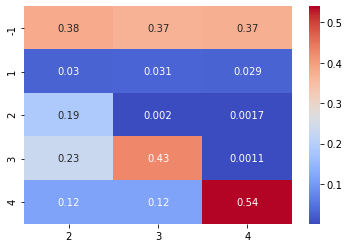

In [33]:
import seaborn as sns

distrib_df = pd.DataFrame(length_distrib_map)
distrib_df = distrib_df / distrib_df.sum()
sns.heatmap(distrib_df.loc[[-1,1,2,3,4]], cmap="coolwarm", annot=True)

## Base fee optimization

In the Lightning Network data that we observed more than 60\% of the nodes charged the default base fee. From a node's position in the network `lnsimulator` can estimate the base fee increment needed to achieve optimal routing by setting `with_node_removals=True` and calling `calc_optimal_base_fee` function afterwards. **For now optimal base fee search is enabled only for cheapest path routing (`weight="total_fee`). We also recommend you apply parallelization by setting a higher value for the `max_threads` parameter.**

In [34]:
sim_fee_opt = ts.TransactionSimulator(directed_edges, providers, amount, count)
shortest_paths, alternative_paths, all_router_fees, _ = sim_fee_opt.simulate(weight="total_fee", with_node_removals=True, max_threads=2)
opt_fee_df, _ = ts.calc_optimal_base_fee(shortest_paths, alternative_paths, all_router_fees)
print(opt_fee_df.head())

Graph and capacities were INITIALIZED
Transactions simulated on original graph STARTED..
Transactions simulated on original graph DONE
Transaction succes rate:
True     0.602201
False    0.397799
Name: success, dtype: float64
Base fee optimization STARTED..
Parallel execution on 2 threads in progress..


  0%|          | 0/503 [00:00<?, ?it/s]

Base fee optimization DONE


100%|██████████| 503/503 [00:04<00:00, 109.02it/s]

                                                node  total_income  \
0  0232e20e7b68b9b673fb25f48322b151a93186bffe4550...        4808.0   
1  03e50492eab4107a773141bb419e107bda3de3d55652e6...        3020.0   
2  0279c22ed7a068d10dc1a38ae66d2d6461e269226c6025...        1500.0   
3  032679fec1213e5b0a23e066c019d7b991b95c6e4d2880...        1311.5   
4  0390b5d4492dc2f5318e5233ab2cebf6d48914881a33ef...        1006.5   

   total_traffic  failed_traffic_ratio  opt_delta  income_diff  
0              8              0.750000        0.0          0.0  
1             20              0.600000        0.0          0.0  
2             25              0.680000        0.0          0.0  
3             43              0.162791        0.0          0.0  
4             33              0.242424        0.0          0.0  


The result of `calc_optimal_base_fee` contains the following informations.

| Column | Description |
|     :---      |   :---   |
| node | LN node public key |
| total_income | routing income |
| total_traffic | number of routed transactions |
| failed_traffic_ratio | ratio of failed transactions out of `total_traffic` payments if `node` is removed from LN  |
| opt_delta | estimated optimal increase in base fee |
| income_diff | estimated increase in daily routing income after applying optimal base fee increment |

In the next step we transform the `opt_delta` column into a categorical feature that represent the increment magnitude.

In [35]:
def to_category(x):
    if x > 100:
        return 3
    elif x > 10:
        return 2
    elif x > 0:
        return 1
    else:
        return 0
    
print("The magnitude distribution of base fee increments:")
print(opt_fee_df["opt_delta"].apply(to_category).value_counts())

The magnitude distribution of base fee increments:
0    325
2    107
1    101
3     18
Name: opt_delta, dtype: int64
